# Лабораторная работа по нейроинформатике №8

Выполнил: _Коростелев Д.В._ Группа: _М8О-408Б-18_ Вариант: _11_


### Задание №1

 Построить и обучить сеть прямого распространения с запаздыванием (Focused Time-Delay
Neural Network, FTDNN), которая будет аппроксимировать последовательность чисел Вольфа, а
также выполнить многошаговый прогноз.


In [1]:
date="1784-05-01"

Открываем датасет и преобразовываем его в нужный вид

In [2]:
import pandas as pd

data = pd.read_csv('data.csv', sep=';', header=None)

In [3]:
data.head()

,0,1,2,3,4,5,6
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


In [4]:
data.index = pd.to_datetime(data[0].astype(str) + '-' + data[1].astype(str))
data.drop([0,1,2,4,5,6], axis=1, inplace=True)
data.head()

,3
1749-01-01,96.7
1749-02-01,104.3
1749-03-01,116.7
1749-04-01,92.8
1749-05-01,141.7


Изобразим полученные результаты

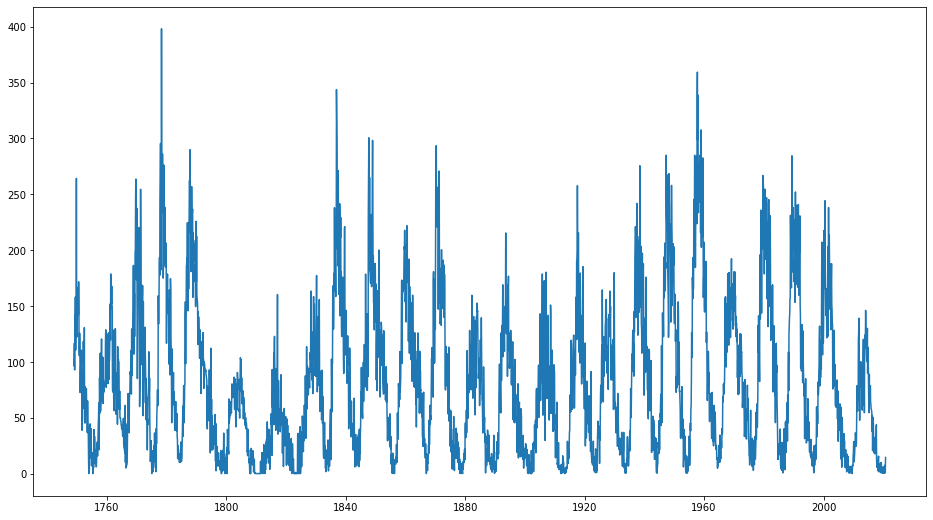

In [5]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 9))
plt.plot(data)

In [6]:
import numpy as np
def smooth_filter(values, width):
    r = np.arange(1, width-1,2)
    f = np.cumsum(values[:(width-1)-1])[::2] / r
    e = (np.cumsum(values[:-(width-1):-1])[::2] / r)[::-1]
    return np.concatenate((f, np.convolve(values, np.ones(width, dtype=int), 'valid') / width, e))

In [7]:
window = 12
values = smooth_filter(data.values.flatten(), window)

Изобразим отфильтрованные результаты

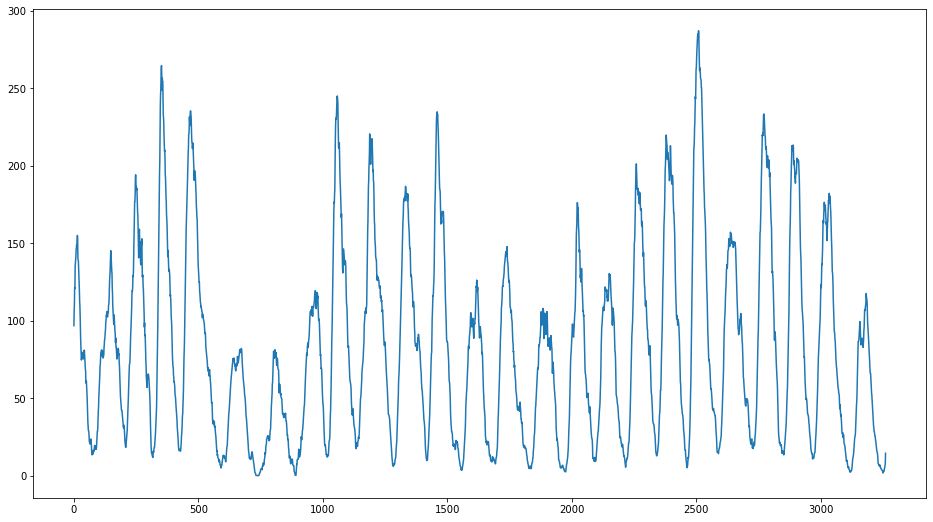

In [8]:
plt.figure(figsize=(16, 9))
plt.plot(values)

Разбиваем множество на обучающую и тестовую выборки

In [9]:
deep = 5
split_index = int(len(values) * 0.7)
train = values[:split_index]
test = values[split_index:]

x_train = np.array([train[i:i + deep] for i in range(len(train) - deep)])
y_train = train[deep:]

x_test = np.array([test[i:i + deep] for i in range(len(test) - deep)])
y_test = test[deep:]

Строим сеть прямого распространения с запаздыванием для предсказания значений
временного ряда и выполнения многошагового прогноза

In [10]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(12, input_dim=deep, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=2, verbose=0)

In [11]:
train_predict = model.predict(x_train)

In [12]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(y_train, train_predict)
print(f'MSE = {error}')
print(f'RMSE = {np.sqrt(error)}')

MSE = 120.00769014743683
RMSE = 10.9548021500818


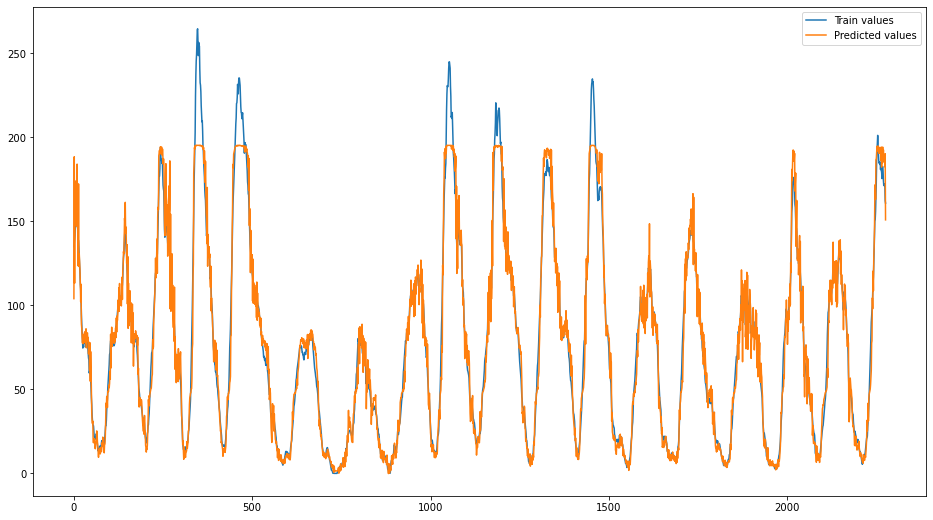

In [13]:
plt.figure(figsize=(16, 9))

plt.plot(y_train)
plt.plot(train_predict)

plt.legend(['Train values', 'Predicted values'])
plt.show()

In [14]:
test_predict = model.predict(x_test)

error = mean_squared_error(y_test, test_predict)
print(f'MSE = {error}')
print(f'RMSE = {np.sqrt(error)}')

MSE = 250.04091359343494
RMSE = 15.812682049337328


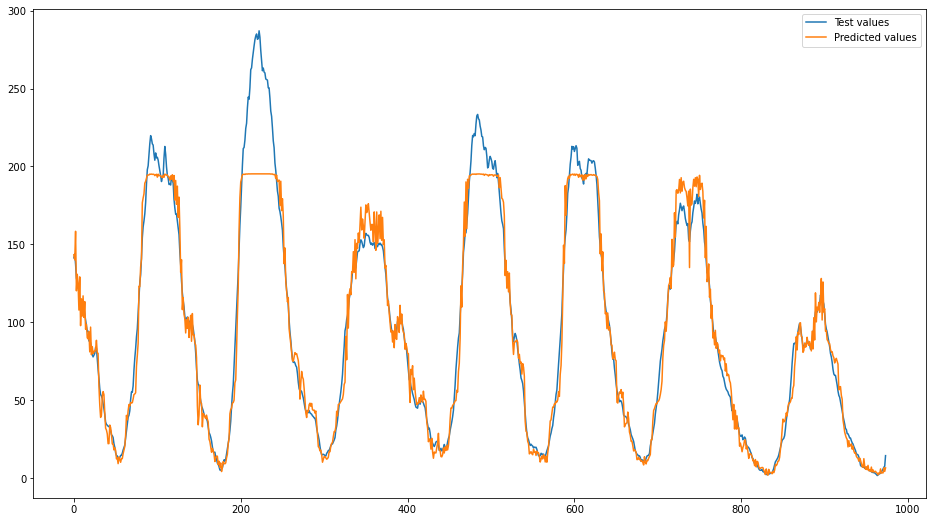

In [15]:
plt.figure(figsize=(16, 9))

plt.plot(y_test)
plt.plot(test_predict)

plt.legend(['Test values', 'Predicted values'])
plt.show()

### Задание №2
Построить и обучить сеть прямого распространения с распределенным запаздыванием
(Distributed Time-Delay Neural Network, TDNN), которая будет выполнять распознавание динамического образ

In [16]:
step = 0.025
interval = (2.9, 4.55)
R = [6,7,1]
g = lambda k: np.cos(((-np.cos(k)) *k) + k)
p1k = np.arange(0, 1, step)
p2k = np.arange(interval[0], interval[1], step)

p1 = np.sin(4 * np.pi * p1k)
p2 = g(p2k).reshape(1, -1)

t1 = np.ones(len(p1k)) * (-1)
t2 = np.ones(len(p2k)).reshape(1, -1)

In [17]:
import numpy.matlib
P = np.concatenate((numpy.matlib.repmat(p1, 1, R[0]), p2,
                    numpy.matlib.repmat(p1, 1, R[1]), p2,
                    numpy.matlib.repmat(p1, 1, R[2]), p2), axis=1).reshape(-1, 1).ravel()

T = np.concatenate((numpy.matlib.repmat(t1, 1, R[0]), t2,
                    numpy.matlib.repmat(t1, 1, R[1]), t2,
                    numpy.matlib.repmat(t1, 1, R[2]), t2), axis=1).reshape(-1, 1).ravel() 

Формируем сеть прямого распространения с распределенным запаздыванием для
распознавания динамических образов.

In [18]:
from pyrenn import CreateNN, train_LM, NNOut

tdnn = CreateNN([1, 8, 1], dIn=[5], dIntern=[5])
tdnn = train_LM(P, T, tdnn, E_stop=1e-5, k_max=100)
tdnn_out = NNOut(P, tdnn)

Maximum number of iterations reached


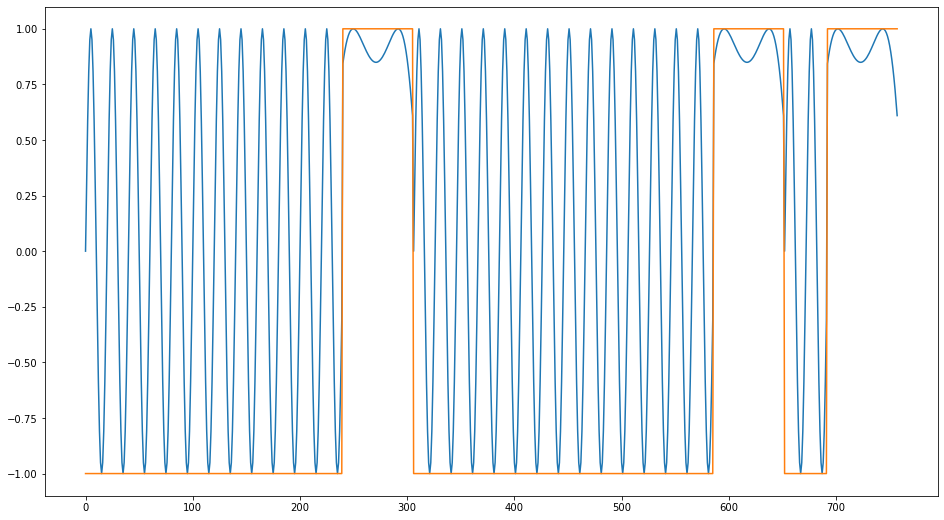

In [19]:
plt.figure(figsize=(16, 9))
plt.plot(P)
plt.plot(T)

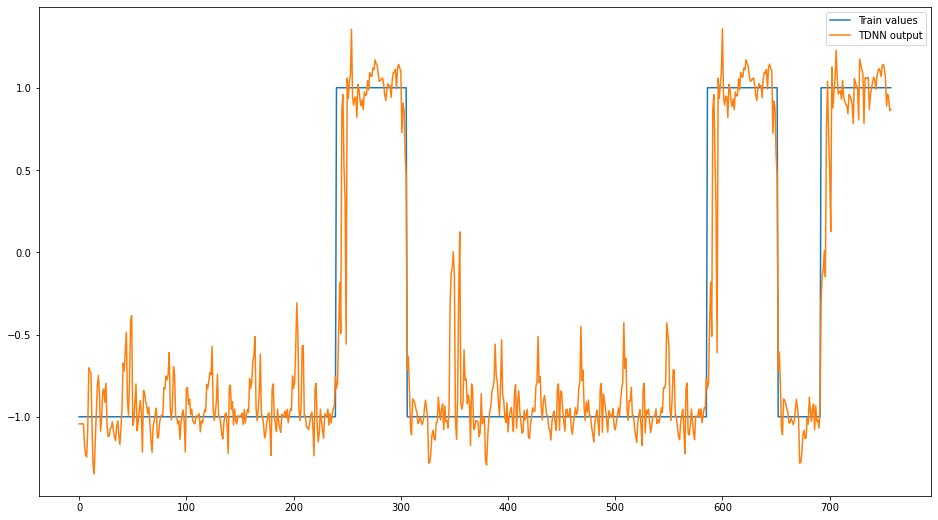

In [20]:
plt.figure(figsize=(16, 9))
plt.plot(T)
plt.plot(tdnn_out)
plt.legend(['Train values', 'TDNN output'])

In [21]:
error = mean_squared_error(T.reshape(T.shape[0]), tdnn_out)
print(f'MSE = {error}')
print(f'RMSE = {error}')

MSE = 0.0795441268335359
RMSE = 0.0795441268335359


Протестируем нейронную сеть

In [22]:
R_test = [1,7,1]
P_test = np.concatenate((numpy.matlib.repmat(p1, 1,R_test[0]), p2,
                    numpy.matlib.repmat(p1, 1, R_test[1]), p2,
                    numpy.matlib.repmat(p1, 1, R_test[2]), p2), axis=1).reshape(-1, 1).ravel()

T_test = np.concatenate((numpy.matlib.repmat(t1, 1, R_test[0]), t2,
                    numpy.matlib.repmat(t1, 1, R_test[1]), t2,
                    numpy.matlib.repmat(t1, 1, R_test[2]), t2), axis=1).reshape(-1, 1).ravel() 

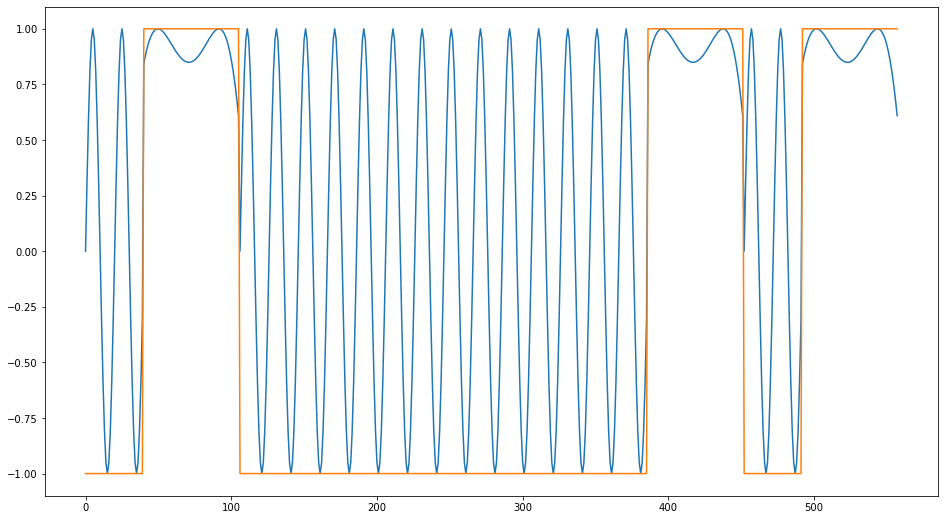

In [23]:
plt.figure(figsize=(16, 9))
plt.plot(P_test)
plt.plot(T_test)

In [24]:
tdnn_out_test = NNOut(P_test, tdnn)

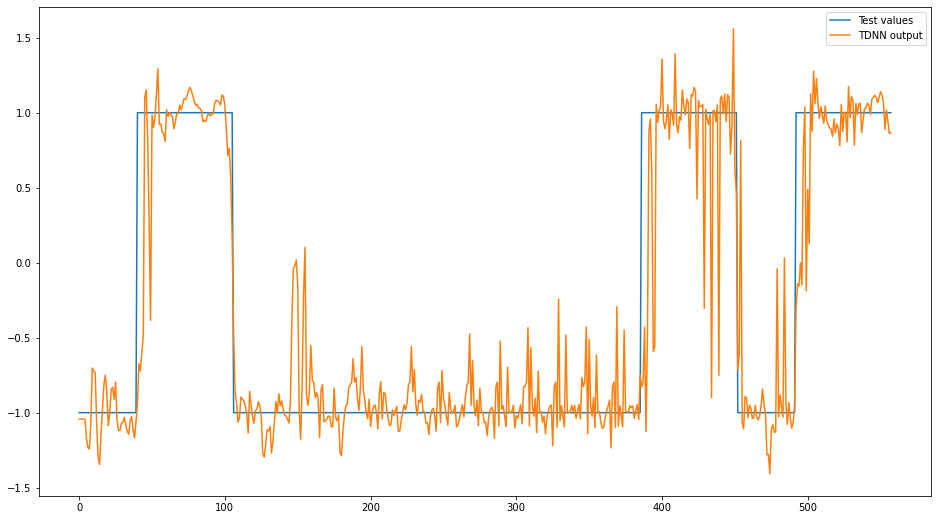

In [25]:
plt.figure(figsize=(16, 9))
plt.plot(T_test)
plt.plot(tdnn_out_test)
plt.legend(['Test values', 'TDNN output'])

In [26]:
error = mean_squared_error(T_test.reshape(T_test.shape[0]), tdnn_out_test)
print(f'MSE = {error}')
print(f'RMSE = {np.sqrt(error)}')

MSE = 0.14219405633936694
RMSE = 0.3770862717460912


### Задание №3
Использовать нелинейную авторегрессионную сеть с внешними входами для аппроксимации траектории динамической системы и выполнения многошагового прогноза.


In [27]:
k = np.arange(0, 10, 0.01)
u = lambda k: np.cos(k*k)
def f(k):
    y = [0.0]
    for i in k:
        y.append(y[-1] / (1 + y[-1] * y[-1]) + u(i)* u(i) * u(i))
    return y[:-1]

In [28]:
y = f(k)
x = u(k)[:, np.newaxis]

In [29]:
delay = 3
shift=10
train_split_index = int(len(y) * 0.7)
test_split_index = int(len(y) * 0.2) + train_split_index

x_train = k[:train_split_index]
y_train = y[:train_split_index]
x_test = k[train_split_index:test_split_index]
y_test = y[train_split_index:test_split_index]
x_valid = k[test_split_index:]
y_valid = y[test_split_index:]

Строим, обучаем и тестируем нелинейную авторегрессионную сеть с внешними входами (Non-linear
AutoRegressive network with eXogeneous inputs, NARX), которая будет выполнять аппроксимацию
траектории динамической системы, также выполнить многошаговый прогноз значений системы

In [30]:
from fireTS.models import NARX
from sklearn.neural_network import MLPRegressor

narx_net = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=600,
                             auto_order=2, exog_order=[2], exog_delay=[delay])

In [31]:
narx_net.fit(x, y)

In [32]:
narx_output = narx_net.predict(x, y, step=1)

In [33]:
narx_output[np.isnan(narx_output)] = 0
error = mean_squared_error(y, narx_output)
print(f'MSE = {error}')
print(f'RMSE = {np.sqrt(error)}')

MSE = 0.008433901569402494
RMSE = 0.09183627589031741


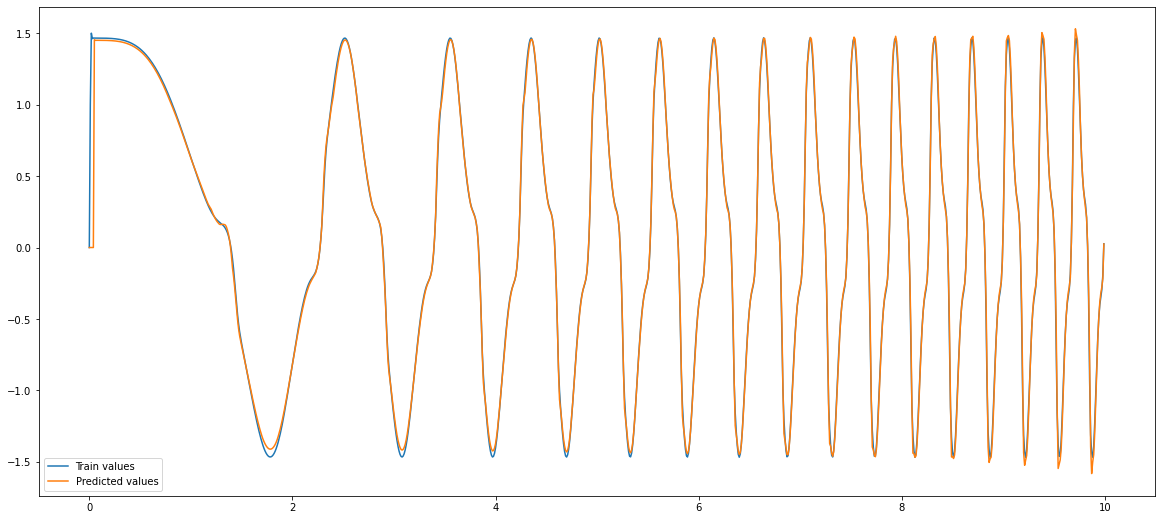

In [34]:
plt.figure(figsize=(20, 9))

plt.plot(k, y)
plt.plot(k, narx_output)
plt.legend(['Train values', 'Predicted values'])

In [35]:
narx_test = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=600,
                         auto_order=2, exog_order=[delay], exog_delay=[delay])
narx_test.fit(x, y)

In [36]:
test_x = u(x_test)[:, np.newaxis]
test_ouput = narx_test.predict(test_x, y_test, step=3)

In [37]:
test_ouput[np.isnan(test_ouput)] = 0
error = mean_squared_error(y_test, test_ouput)
print(f'MSE = {error}')
print(f'RMSE = {np.sqrt(error)}')

MSE = 0.02257680368027004
RMSE = 0.15025579416538332


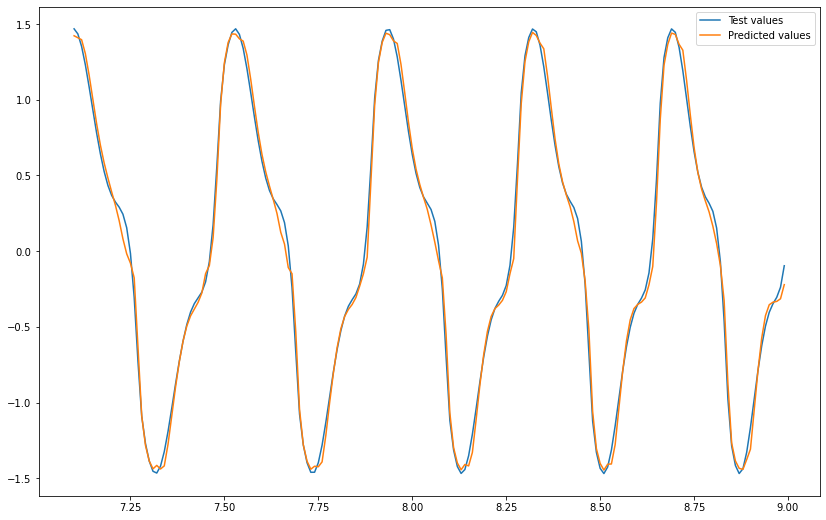

In [38]:
plt.figure(figsize=(14, 9))

plt.plot(x_test[shift:], y_test[shift:])
plt.plot(x_test[shift:], test_ouput[shift:])
plt.legend(['Test values', 'Predicted values'])

### Вывод


В 8ой лабораторной работе требовалось построить и обучить две нейронные сети с временными задержками для аппроксимации активности на Солнце, классификации изменяющейся функции и аппроксимации динамического образа. 

Конкретно в данной лабораторной работе возникли проблема с обучением FTDNN нейронной сети. При обучении и тестировании в районах точек максимумов функции нейронная сеть срывалась и предсказанные значения образовывали своеобразное «плато». Данная проблема с большой вероятностью связана с изначальным выбором RELU функции активации на втором слое, после установления Tanh проблема стала иметь менее значительный характер (во время предсказания по обучающему множеству), после небольшого повышения количества эпох удалось добиться значительного уменьшения ошибки на обучающем множестве. К сожалению, на тестовом множестве все также можно наблюдать срывы на некоторых участках образа. Но в нейронная сеть неплохо справляется со своей задачей даже с учетом этого недостатка.
